<a href="https://colab.research.google.com/github/mandelatrey/ML/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.12.0


In [3]:
VOCAB_SIZE = 15000
ATTENTION_DIM = 512
WORD_EMBEDDING_DIM = 128

FEATURES_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet'
)

IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


In [4]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

def get_image_label(example):
    caption = example["captions"]["text"][0]
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)


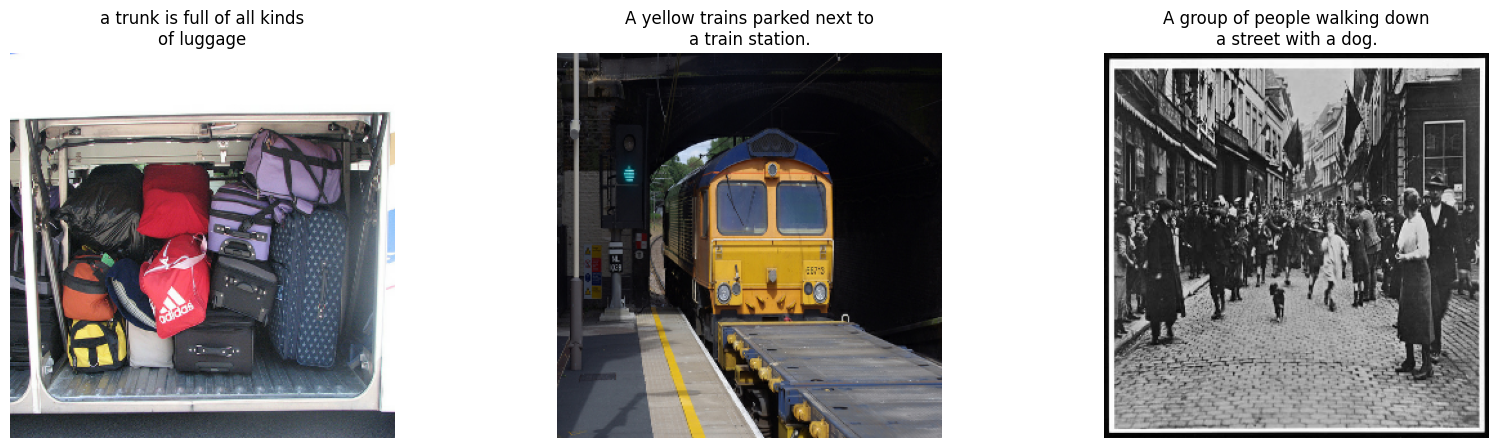

In [5]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
for idx, data in enumerate(trainds.take(3)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

In [6]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

In [7]:
# %%time
MAX_CAPTION_LEN = 64

def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )

tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE, standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

In [8]:
tokenizer(["<start> This is a good sentence example <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   1,  165,   11,    2, 1208,    1, 6405,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [9]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [10]:
sample_captions

[b'<start A giraffe reaching up to a tree for leaves <end>',
 b'<start there is a man pointing out to another man in the ocean <end>',
 b'<start Several plates filled with meat, rice, and vegetables. <end>',
 b'<start A street sign that points to the right, on a light post. <end>',
 b'<start a stop sign and two blue and white street signs and buildings <end>']

In [11]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3    2  105  697   41   13    2  127   99  487    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3   79   11    2   12  885  106   13  205   12    8    7  164    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3  125  284   76    9  345  607   10  213    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [12]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start a giraffe reaching up to a tree for leaves <end>                                                      

In [13]:
#lookup table: Word --> Index 
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

#lookup table: Index --> Word 
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [14]:
BATCH_SIZE = 32

def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return(img_tensor, caption), target

batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [15]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  48  28  72   2 434 551  10   2 166   8  35   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  48  28  72   2 434 551  10   2 166   8  35   4   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  31   5  20 156   2  69   6   7  77   4   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

In [16]:
FEATURES_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURES_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)

encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [17]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


In [18]:
word_inputs = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_inputs)

decoder_gru = GRU(ATTENTION_DIM,
                  return_sequences=True,
                  return_state=True)

gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

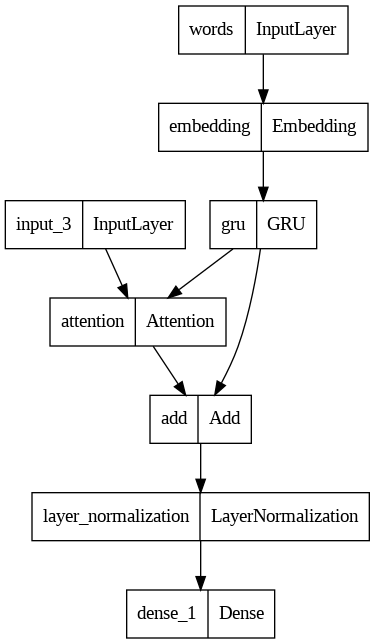

In [19]:
#visual model structure
decoder = tf.keras.Model(
    inputs=[word_inputs, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [20]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 512)      7680000     ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 64, 512),    1575936     ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

#Training the model

In [21]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_inputs], outputs=decoder_output
)

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    #return 1 to word idx and 0 for padding
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_)


In [23]:
image_caption_train_model.compile(
    optimizer="adam", loss=loss_function
)

In [24]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=2)

Epoch 1/2
2586/2586 [==============================] - 949s 355ms/step - loss: 0.5595
Epoch 2/2
2586/2586 [==============================] - 914s 351ms/step - loss: 0.4194
CPU times: user 28min 39s, sys: 2min 3s, total: 30min 43s
Wall time: 31min 3s


In [26]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

#we reuse the trained GRU, updating it so that it can receive states
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

#defining the prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_inputs, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state]
)


In [43]:
MINIMUM_SENTENCE_LENGTH = 10

def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), 
                               channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []

    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features])
        
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id ==  word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

in the back of a person and a cell phone.
a cell phone with a man in it.
and a smart phone in a parking space on a lawn.
in a beautiful woman in a white dress holding a smart phone to a woman.
                                                              .


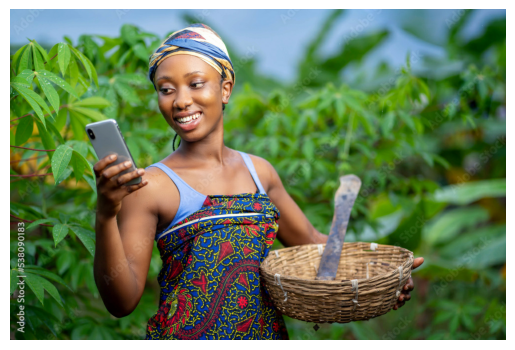

In [45]:
filename = "/content/img4.jpeg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");
